In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
import keras
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from keras.layers import Convolution1D, MaxPool1D, Flatten, Activation, Dense, GlobalAveragePooling1D, Input,Dropout, LeakyReLU, BatchNormalization
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Nadam,Adam, SGD
from keras.utils import to_categorical 

Using TensorFlow backend.


In [0]:
train = pd.read_csv('/gdrive/My Drive/Titanic/train.csv')
test = pd.read_csv('/gdrive/My Drive/Titanic/test.csv')
submission = pd.read_csv('/gdrive/My Drive/Titanic/gender_submission.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
submission

,PassengerId,Survived
0,892,NaN
1,893,NaN
2,894,NaN
3,895,NaN
4,896,NaN
...,...,...
413,1305,NaN
414,1306,NaN
415,1307,NaN
416,1308,NaN


# 전처리
## Name -> 칭호만 분리


In [7]:
train.iloc[0]['Name']

'Braund, Mr. Owen Harris'

In [0]:
for ind,name in enumerate(train['Name']):
  train.loc[train.PassengerId == ind+1,'Name'] = name.split('.')[0].split(' ')[-1]

for ind,name in enumerate(test['Name']):
  test.loc[test.index == ind,'Name'] = name.split('.')[0].split(' ')[-1]


In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Mr,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,Mrs,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,Mrs,female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,Mr,male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,Mr,male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,Mrs,female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,Mr,male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,Mr,male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,Mrs,female,22.0,1,1,3101298,12.2875,NaN,S


## Cabin -> 알파벳 분리

In [0]:
for ind,cabin in enumerate(train['Cabin']):
  if type(cabin) == float:
    continue
  train.loc[train.PassengerId == ind+1,'Cabin'] = cabin[0]#알파벳만 분리

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Mr,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,Mrs,female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,Mrs,female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,Mr,male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
for ind,cabin in enumerate(test['Cabin']):
  if type(cabin) == float:
    continue
  test.loc[test.index == ind,'Cabin'] = cabin[0]
test.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,Mr,male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,Dona,female,39.0,0,0,PC 17758,108.9000,C,C
415,1307,3,Mr,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,Mr,male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,Master,male,NaN,1,1,2668,22.3583,NaN,C


## object -> int

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


--> Object 타입:Name, Sex, Ticket, Cabin, Embarked

- Name 칭호별 인덱싱

In [0]:
t_set = set(train.Name)|set(test.Name)
dic_Name = {i:j for i,j in zip(t_set,[k for k in range(len(t_set))])}

In [16]:
dic_Name

{'Capt': 15,
 'Col': 5,
 'Countess': 3,
 'Don': 0,
 'Dona': 13,
 'Dr': 8,
 'Jonkheer': 16,
 'Lady': 6,
 'Major': 17,
 'Master': 2,
 'Miss': 11,
 'Mlle': 14,
 'Mme': 4,
 'Mr': 7,
 'Mrs': 10,
 'Ms': 1,
 'Rev': 9,
 'Sir': 12}

In [0]:
for k,v in dic_Name.items():
  train['Name'].replace(k,v,inplace = True)
  test['Name'].replace(k,v,inplace = True)

In [18]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,7,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,10,female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,11,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,10,female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,7,male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,9,male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,11,female,19.0,0,0,112053,30.0000,B,S
888,889,0,3,11,female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,7,male,26.0,0,0,111369,30.0000,C,C


In [19]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,7,male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,10,female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,7,male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,7,male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,10,female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,7,male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,13,female,39.0,0,0,PC 17758,108.9000,C,C
415,1307,3,7,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,7,male,NaN,0,0,359309,8.0500,NaN,S


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null int64
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null int64
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 36.0+ KB


- Sex 인덱싱


In [0]:
dic_Sex = {'female':0, 'male':1}

In [0]:
for k,v in dic_Sex.items():
  train['Sex'].replace(k,v, inplace =True)
  test['Sex'].replace(k,v,inplace=True)


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null int64
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(7), object(3)
memory usage: 83.7+ KB


In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null int64
Sex            418 non-null int64
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(6), object(3)
memory usage: 36.0+ KB


- Cabin 인덱싱

In [26]:
set_cabin = set(train.Cabin)|set(test.Cabin)
set_cabin

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', nan}

In [0]:
dic_cabin = {i:e for e,i in enumerate(set_cabin)}

In [28]:
dic_cabin

{'A': 4, 'B': 2, 'C': 5, 'D': 1, 'E': 8, 'F': 6, 'G': 3, 'T': 7, nan: 0}

In [0]:
for k,v in dic_cabin.items():
  train['Cabin'].replace(k,v,inplace = True)
  test['Cabin'].replace(k,v,inplace = True)

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null int64
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null int64
Embarked       889 non-null object
dtypes: float64(2), int64(8), object(2)
memory usage: 83.7+ KB


In [31]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null int64
Sex            418 non-null int64
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          418 non-null int64
Embarked       418 non-null object
dtypes: float64(2), int64(7), object(2)
memory usage: 36.0+ KB


- Embarked 인덱싱

In [32]:
set_Embarked = set(train.Embarked)|set(test.Embarked)
set_Embarked

{'C', 'Q', 'S', nan}

In [0]:
dic_Embarked = {i:e for e,i in enumerate(set_Embarked)}
for k,v in dic_Embarked.items():
  train['Embarked'].replace(k,v, inplace = True)
  test['Embarked'].replace(k,v, inplace = True)


In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null int64
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null int64
Embarked       891 non-null int64
dtypes: float64(2), int64(9), object(1)
memory usage: 83.7+ KB


In [35]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null int64
Sex            418 non-null int64
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          418 non-null int64
Embarked       418 non-null int64
dtypes: float64(2), int64(8), object(1)
memory usage: 36.0+ KB


- Ticket 살펴보기

In [0]:
#set(test.Ticket)

In [0]:
#set(train.Ticket)

In [0]:
Ticket_cnt =pd.DataFrame([len(set(train.Ticket)), len(set(test.Ticket)), len(set(train.Ticket)|set(test.Ticket))], ['train','test','train+test'], columns = ['type_count'])

In [39]:
Ticket_cnt

,type_count
train,681
test,363
train+test,929


-------------------------------
train, test 각각의 샘플에서 Ticket번호가 겹치는 경우도 있고,
<br>
train+test에서도 같은 Ticket번호가 있다.
<br>
위에서 살펴본 바, 길이 3이 가장 짧은 길이의 Ticket 번호이다. 
<br> 
따라서 Ticket번호 길이를 모두 3으로 잘라내는 건 어떨까


---



In [0]:
for ind,ticket in enumerate(train.Ticket):
  train.loc[train.index == ind, 'Ticket'] = ticket[:3] 

for ind,ticket in enumerate(test.Ticket):
  test.loc[test.index == ind, 'Ticket'] = ticket[:3] 

In [41]:
Ticket_cnt['type_count(after)'] = [len(set(train.Ticket)), len(set(test.Ticket)),len( set(train.Ticket)|set(test.Ticket))]
Ticket_cnt

,type_count,type_count(after)
train,681,154
test,363,117
train+test,929,171


In [0]:
#많이 줄어들었으니, 이것도 인덱싱 해보자
set_ticket = set(train.Ticket)|set(test.Ticket)
#set_ticket

In [0]:
dic_ticket = {i:e for e,i in enumerate(set_ticket)}
#dic_ticket

In [0]:
for k,v in dic_ticket.items():
  train['Ticket'].replace(k,v, inplace = True)
  test['Ticket'].replace(k,v, inplace = True)

In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null int64
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null int64
Fare           891 non-null float64
Cabin          891 non-null int64
Embarked       891 non-null int64
dtypes: float64(2), int64(10)
memory usage: 83.7 KB


In [46]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null int64
Sex            418 non-null int64
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null int64
Fare           417 non-null float64
Cabin          418 non-null int64
Embarked       418 non-null int64
dtypes: float64(2), int64(9)
memory usage: 36.0 KB


## 결측치 처리

In [47]:
train.Age.fillna(value = train.Age.mean(),axis = 0,inplace = True)
train.describe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,8.069585,0.647587,29.699118,0.523008,0.381594,70.618406,32.204208,0.937149,2.631874
std,257.353842,0.486592,0.836071,2.282244,0.477990,13.002015,1.102743,0.806057,47.443950,49.693429,2.053903,0.647601
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,7.000000,0.000000,22.000000,0.000000,0.000000,34.000000,7.910400,0.000000,2.000000
50%,446.000000,0.000000,3.000000,7.000000,1.000000,29.699118,0.000000,0.000000,60.000000,14.454200,0.000000,3.000000
75%,668.500000,1.000000,3.000000,10.000000,1.000000,35.000000,1.000000,0.000000,110.000000,31.000000,0.000000,3.000000
max,891.000000,1.000000,3.000000,17.000000,1.000000,80.000000,8.000000,6.000000,170.000000,512.329200,8.000000,3.000000


In [48]:
test.Age.fillna(value = test.Age.mean(), axis = 0,inplace = True)
test.describe()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,417.000000,418.000000,418.000000
mean,1100.500000,2.265550,8.014354,0.636364,30.272590,0.447368,0.392344,71.610048,35.627188,0.897129,2.535885
std,120.810458,0.841838,2.233339,0.481622,12.634534,0.896760,0.981429,46.378369,55.907576,1.964051,0.685516
min,892.000000,1.000000,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,996.250000,1.000000,7.000000,0.000000,23.000000,0.000000,0.000000,36.000000,7.895800,0.000000,2.000000
50%,1100.500000,3.000000,7.000000,1.000000,30.272590,0.000000,0.000000,64.000000,14.454200,0.000000,3.000000
75%,1204.750000,3.000000,10.000000,1.000000,35.750000,1.000000,0.000000,107.000000,31.500000,0.000000,3.000000
max,1309.000000,3.000000,13.000000,1.000000,76.000000,8.000000,9.000000,169.000000,512.329200,8.000000,3.000000


In [49]:
test.Fare.fillna(value = test.Fare.mean(), axis=0, inplace = True)
test.describe()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,8.014354,0.636364,30.272590,0.447368,0.392344,71.610048,35.627188,0.897129,2.535885
std,120.810458,0.841838,2.233339,0.481622,12.634534,0.896760,0.981429,46.378369,55.840500,1.964051,0.685516
min,892.000000,1.000000,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,996.250000,1.000000,7.000000,0.000000,23.000000,0.000000,0.000000,36.000000,7.895800,0.000000,2.000000
50%,1100.500000,3.000000,7.000000,1.000000,30.272590,0.000000,0.000000,64.000000,14.454200,0.000000,3.000000
75%,1204.750000,3.000000,10.000000,1.000000,35.750000,1.000000,0.000000,107.000000,31.500000,0.000000,3.000000
max,1309.000000,3.000000,13.000000,1.000000,76.000000,8.000000,9.000000,169.000000,512.329200,8.000000,3.000000


# 피처 선택

In [0]:
feature_all = ['Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
feature5_1 = ['Pclass', 'Sex','SibSp','Parch','Fare']
feature5_2 = ['Pclass', 'Name','SibSp','Parch','Fare']
feature6_1 = ['Pclass', 'Name','Age','SibSp','Parch','Fare']
feature6_2 = ['Pclass', 'Sex','Age','SibSp','Parch','Fare']


In [0]:

def t_model(n):
  model = Sequential()
  model.add(Dense(units= 10, activation = 'selu',input_shape=(n,)))
  model.add(Dense(units =20, activation = 'selu'))
  model.add(Dense(units= 30, activation='selu'))
  model.add(Dense(units= 40, activation='selu'))
  model.add(Dense(units= 50, activation='selu'))
  model.add(Dropout(0.3))
  model.add(Dense(units= 1, activation='sigmoid'))
  return model




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


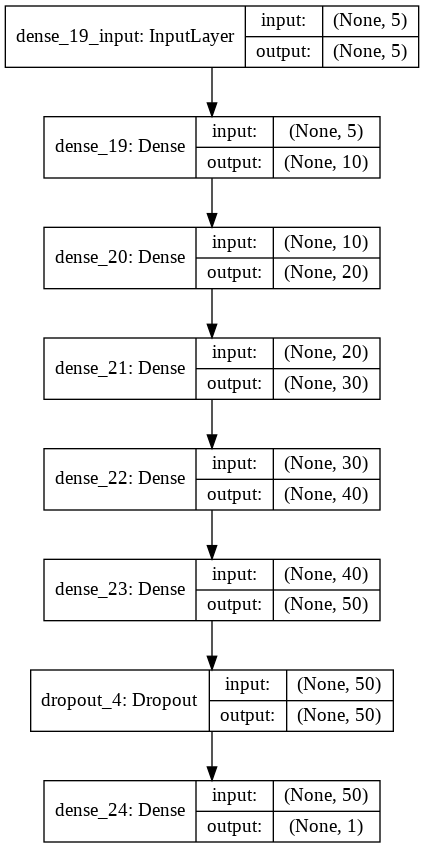

In [65]:
from keras.utils.vis_utils import plot_model
feature = feature5_1
n = len(feature)
model = t_model(n)
plot_model(model,to_file='/gdrive/My Drive/Titanic/Titanic_model+{}.png'.format(n), show_shapes=True, show_layer_names=True)

In [66]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_20 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_21 (Dense)             (None, 30)                630       
_________________________________________________________________
dense_22 (Dense)             (None, 40)                1240      
_________________________________________________________________
dense_23 (Dense)             (None, 50)                2050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                

In [0]:
train_X = train[feature]
train_Y = train['Survived']
test_X = test[feature]

In [0]:
ep=300
model.compile(optimizer = Adam(lr = 0.001),metrics = ['accuracy'], loss='binary_crossentropy')
#모델을 학습합니다.
model_ch = ModelCheckpoint('/gdrive/My Drive/Check/model1_feature5_1_b10_{epoch}.h5',save_weights_only=True,period= 100) 
hist = model.fit(train_X, train_Y, epochs=ep, batch_size=10, validation_split = 0.3, verbose = 1, shuffle = True,callbacks=[model_ch])
#model.save('/gdrive/My Drive/Titanic/model1.h5')

pred_test = model.predict(test_X)
submission['Survived'] = [int(np.round(i)) for i in pred_test]
submission.to_csv('/gdrive/My Drive/Titanic/feature5_1_model1_{}_b10.csv'.format(ep),index=False)
submission

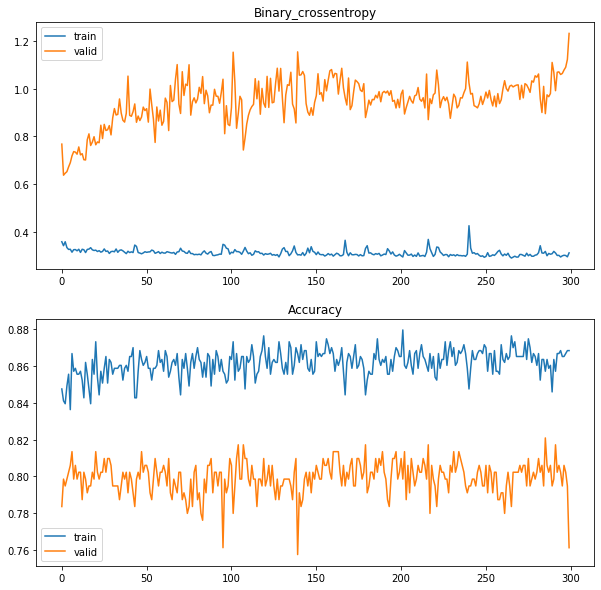

In [101]:
plt.figure(figsize = (10,10))
plt.subplot(211)
plt.title('Binary_crossentropy')
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()

plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()

In [102]:
submission['Survived'].value_counts()

0    274
1    144
Name: Survived, dtype: int64

In [0]:
# model = t_model(n)
# model.load_weights('/gdrive/My Drive/Check/model1_feature5_1_600.h5')


In [98]:
# pred_test = model.predict(test_X)
# submission['Survived'] = [int(np.round(i)) for i in pred_test]
# submission.to_csv('/gdrive/My Drive/Titanic/feature5_1_model1_{}.csv'.format(600),index=False)
# submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [99]:
# submission['Survived'].value_counts()

0    260
1    158
Name: Survived, dtype: int64